    6/25 請每位同學利用實際金融商品資料(由同學決定商品)，擇一跑ARMA模型或共整合模型，當作期末報告，需將過程與結果詳加描述
          請上傳繳交PDF檔、程式檔、資料檔
          p.s若寫ARMA主題同學，並須將整個建構ARMA過程完整說明，並詳述此模型預測能力好不好?
             若寫共整合主題的同學，並須將整個建構共整合過程完整說明，並詳述共整合關係、誤差修正項與下期走勢的關係。

    第三個環境

# ARMA模型

In [242]:
#呼叫套件
import math
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import xlrd
import pandas_datareader as pdr
import yfinance as yf

from arch.unitroot import ADF, KPSS        # python=3.7以上
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import *
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa import arima_model
import statsmodels.stats.stattools as smss

np.set_printoptions(suppress=True) #不要科學記號
pd.set_option('display.float_format',lambda x : '%.4f' % x)
pd.set_option('display.max_rows', 10)  

    樣本標的 : 0052 富邦科技 ETF
    樣本區間 : 2020/06/10 ~ 2021/06/11，共 246 天
    資料來源 : CMONEY 日收盤表排行

In [243]:
df = pd.read_csv("富邦科技.csv")
df["日期"] = pd.to_datetime(df["日期"])    #轉換字元為日期時間型別
df.sort_values("日期", inplace=True)      #用時間先後序列排序資料
df = df.reset_index(drop=True)

df = df[['日期','收盤價']]
df.head(3)

,日期,收盤價
0,2020-06-10,68.6900
1,2020-06-11,68.0000
2,2020-06-12,67.5500


## Step 1 : Data Identification

### 1. 單根檢定 Unit root test 並差分

In [244]:
from arch.unitroot import PhillipsPerron
def Unit_root_test(df):
    print( ADF(df ,max_lags=10).summary().as_text() ) # ADF test
    print( PhillipsPerron(df).summary().as_text() )  # PP test
    print( KPSS(df).summary().as_text() ) # KPSS test

In [245]:
Unit_root_test(df['收盤價'])

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.587
P-value                         0.490
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.525
P-value                         0.521
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  2.145
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null 

    ADF test : p=0.490 > 0.05，接受H0(有單根，非定態) => 有單根
    PP  test : p=0.521 > 0.05，接受H0(有單根，非定態) => 有單根
    KPSS test: p=0.000 < 0.05，拒絕H0(存在弱定態)     => 有單根
    結論: 收盤價為非定態數列，所以需要差分
#### 一階差分

In [246]:
df['一階差分'] = df['收盤價'].diff()
df.head(3)

,日期,收盤價,一階差分
0,2020-06-10,68.6900,NaN
1,2020-06-11,68.0000,-0.6900
2,2020-06-12,67.5500,-0.4500


In [247]:
Unit_root_test(df['一階差分'].dropna())

   Augmented Dickey-Fuller Results   
Test Statistic                -13.712
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -13.597
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.133
P-value                         0.446
Lags                                2
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null 

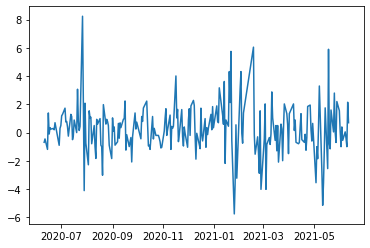

In [248]:
fig, ax = plt.subplots()   
ax.plot(df['日期'],df['一階差分'])

    ADF test : p=0.000 < 0.05，拒絕H0(有單根，非定態) => 無單根
    PP  test : p=0.000 < 0.05，拒絕H0(有單根，非定態) => 無單根
    KPSS test: p=0.446 > 0.05，接受H0(存在弱定態)     => 無單根
    結論: 收盤價的一階差分為定態數列

### 2. 檢查是否為白噪音 Ljung-Box statistic

In [249]:
# statsmodels.tsa.stattools.q_stat(x, nobs, type=None)
# x: Array of autocorrelation coefficients. Can be obtained from acf.
# nobs: Number of observations in the entire sample (ie., not just the length of the autocorrelation function results.
LjungBox = stattools.q_stat(stattools.acf(df['一階差分'].dropna())[1:12],len(df['一階差分'].dropna()))
LjungBox[1][-1]

0.22887816913976655

## Step 2 : 模型估計

### ACF & PACF

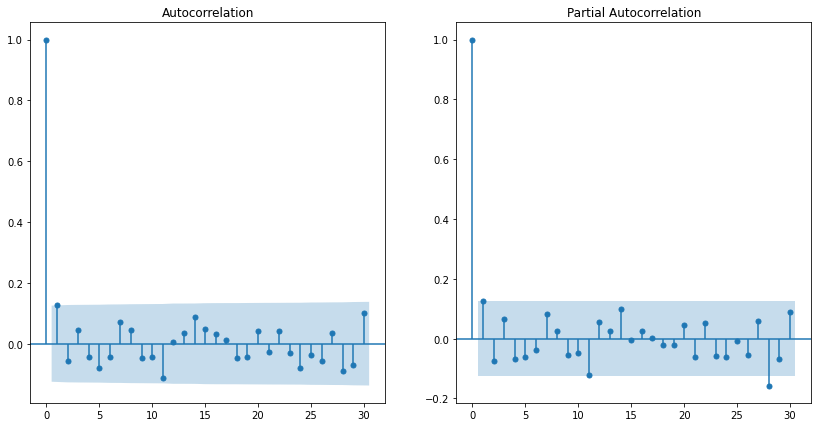

In [250]:
fig, ax = plt.subplots(2, 1, figsize=(14,7))
axe1 = plt.subplot(121)
axe2 = plt.subplot(122)
ax[0] = plot_acf(df['一階差分'].dropna(), lags=30, ax=axe1)   # ACF  決定 MA 落後幾期
ax[1] = plot_pacf(df['一階差分'].dropna(), lags=30, ax=axe2)  # PACF 決定 AR 落後幾期

### Find the smallest AIC

In [251]:
# ARMA(1,1)
model1 = arima_model.ARIMA(df['一階差分'].dropna(), order=(1,0,1)).fit()
print(model1.summary())
#Clear console 不要看到粉紅色緊語!
import warnings
warnings.filterwarnings("ignore")

                              ARMA Model Results                              
Dep. Variable:                   一階差分   No. Observations:                  245
Model:                     ARMA(1, 1)   Log Likelihood                -477.405
Method:                       css-mle   S.D. of innovations              1.698
Date:                Tue, 22 Jun 2021   AIC                            962.811
Time:                        18:33:56   BIC                            976.816
Sample:                             0   HQIC                           968.451
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2307      0.119      1.935      0.053      -0.003       0.464
ar.L1.一階差分    -0.4706      0.225     -2.095      0.036      -0.911      -0.030
ma.L1.一階差分     0.6166      0.198      3.107      0.0

In [252]:
# Try find a best ARMA model parameter
def find_best(time_series):
    aic = []
    for p in range(1,6):
        for q in range(1,6):
            model = arima_model.ARIMA(time_series, order=(p,0,q)).fit()
            aic.append(model.aic)
            print(f"AIC of model ({p},{q}): {model.aic}")
    print(f"Smallest AIC model: ({aic.index(min(aic))//p+1}, {aic.index(min(aic))%p+1}) , AIC = {min(aic)}")

In [253]:
find_best(df['一階差分'].dropna())

AIC of model (1,1): 962.8108519422682
AIC of model (1,2): 964.7944962998286
AIC of model (1,3): 966.6535500161867
AIC of model (1,4): 967.5693314879525
AIC of model (1,5): 968.632603477375
AIC of model (2,1): 964.7922859285933
AIC of model (2,2): 964.9144893252951
AIC of model (2,3): 962.2303498623808
AIC of model (2,4): 960.0371840257175
AIC of model (2,5): 962.0274011103731
AIC of model (3,1): 966.6470072393429
AIC of model (3,2): 968.6292028604778
AIC of model (3,3): 963.2808906015997
AIC of model (3,4): 962.0200916000178
AIC of model (3,5): 963.2275518906886
AIC of model (4,1): 967.4227012975218
AIC of model (4,2): 960.4749085367005
AIC of model (4,3): 962.2376603663163
AIC of model (4,4): 958.7157645788958
AIC of model (4,5): 959.8801983786637
AIC of model (5,1): 969.1085065918867
AIC of model (5,2): 962.3778685101647
AIC of model (5,3): 964.0762971895495
AIC of model (5,4): 965.8468453374802
AIC of model (5,5): 960.7443152607544
Smallest AIC model: (4, 4) , AIC = 958.715764578895

In [254]:
model_44 = arima_model.ARIMA(df['一階差分'].dropna(), order=(4,0,4)).fit()
print(model_44.summary())

                              ARMA Model Results                              
Dep. Variable:                   一階差分   No. Observations:                  245
Model:                     ARMA(4, 4)   Log Likelihood                -469.358
Method:                       css-mle   S.D. of innovations              1.615
Date:                Tue, 22 Jun 2021   AIC                            958.716
Time:                        18:34:21   BIC                            993.728
Sample:                             0   HQIC                           972.815
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2308      0.120      1.924      0.054      -0.004       0.466
ar.L1.一階差分    -0.9116      0.063    -14.368      0.000      -1.036      -0.787
ar.L2.一階差分    -0.1338      0.087     -1.531      0.1

## Step 3 : 模型診斷
### ARMA(4,4)

Figure(432x288)


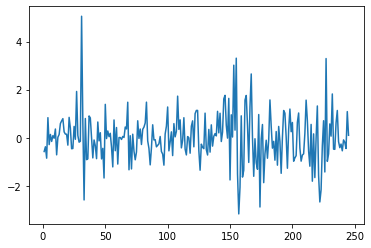

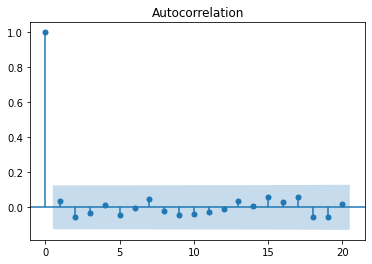

In [255]:
stdresid = model_min.resid / math.sqrt(model_44.sigma2)
plt.plot(stdresid)
print(plot_acf(stdresid,lags=20))

In [256]:
LjungBox = stattools.q_stat(stattools.acf(stdresid)[1:10],len(stdresid))
LjungBox[1][-1]

0.9599261222726837

## Step 4: 模型預測
### ARMA(5,5)

In [257]:
# 一階差分還原成股價
def undo_diff(las_ob, arr):
    a = []
    for i in range(len(arr)):
        las_ob = las_ob + arr[i]
        a.append(las_ob)
    return pd.DataFrame(a)

In [258]:
# 利用ARMA(4,4) 預測未來 6 期一階差分
print( model_44.forecast(6)[0] )
df_pred_44 = undo_diff(df['收盤價'].loc[len(df)-1], model_44.forecast(6)[0])
df_pred_44

[ 0.61688262  0.2734045   0.16435665 -0.2446112   0.33375478  0.22391592]


,0
0,126.0669
1,126.3403
2,126.5046
3,126.2600
4,126.5938
5,126.8177


### ARMA(4,5) AIC倒數第二小

In [259]:
# 利用ARMA(4,5) 預測未來 6 期一階差分
model_45 = arima_model.ARIMA(df['一階差分'].dropna(), order=(4,0,5)).fit()
print( model_45.forecast(6)[0] )
df_pred_45 = undo_diff(df['收盤價'].loc[len(df)-1], model_45.forecast(6)[0])
df_pred_45

[ 0.75659032  0.35441006  0.07416857 -0.33873684  0.28022304  0.32357892]


,0
0,126.2066
1,126.5610
2,126.6352
3,126.2964
4,126.5767
5,126.9002


In [260]:
df_real = pd.read_csv("富邦科技0615-0622.csv")
df_real["日期"] = pd.to_datetime(df_real["日期"])  #轉換字元為日期時間型別
df_real.sort_values("日期", inplace=True)          #用時間先後序列排序資料
df_real = df_real.reset_index(drop=True)          #將日期時間擺放至列索引值
df_real = df_real[['日期','收盤價']]
df_real

,日期,收盤價
0,2021-06-15,126.5500
1,2021-06-16,126.1000
2,2021-06-17,126.5000
3,2021-06-18,126.2000
4,2021-06-21,122.7000
5,2021-06-22,122.0000


In [261]:
df_compare = pd.concat([df_real, df_pred_44, df_pred_45], axis=1)
df_compare.columns = ['日期', '收盤價', 'ARMA(4,4)', 'ARMA(4,5)']
df_compare

,日期,收盤價,"ARMA(4,4)","ARMA(4,5)"
0,2021-06-15,126.5500,126.0669,126.2066
1,2021-06-16,126.1000,126.3403,126.5610
2,2021-06-17,126.5000,126.5046,126.6352
3,2021-06-18,126.2000,126.2600,126.2964
4,2021-06-21,122.7000,126.5938,126.5767
5,2021-06-22,122.0000,126.8177,126.9002


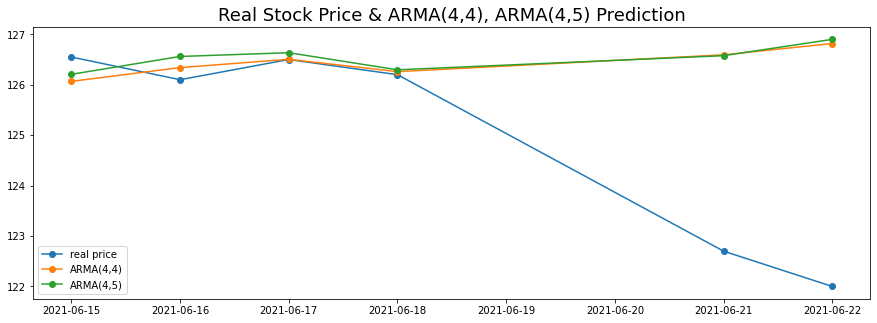

In [262]:
fig, ax = plt.subplots( figsize=(15,5))   
ax.plot(df_compare['日期'], df_compare['收盤價'], marker='o')
ax.plot(df_compare['日期'], df_compare['ARMA(4,4)'], marker='o')
ax.plot(df_compare['日期'], df_compare['ARMA(4,5)'], marker='o')
ax.set_title('Real Stock Price & ARMA(4,4), ARMA(4,5) Prediction',fontsize=18)
ax.legend(labels = ['real price','ARMA(4,4)', 'ARMA(4,5)'])